# Reaching multiple targets with a manipulator
The objective of this exercise is to reach multiple targets with a manipulator.

We provide a basic example for reaching one point, and you have to modify it for sequence of multiple targets. Below it is the basic example, there we'll guide you to the final result.


## Set up

In [1]:
import magic_donotload

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide the solutions to some questions. Change it for %load if you want to see (and execute) the solution.


We will need crocoddyl as in the previous notebook, with the model of the arm of the humanoid robot Talos, a 7-dof arm. It can be found in example robot data.

In [2]:
import crocoddyl
import pinocchio
import numpy as np
import example_robot_data as robex

## The optimal-control program

First, let's load the Pinocchio model for the Talos arm.

In [3]:
robot = robex.load('talos_arm')
robot_model = robot.model

Set robot model.

In [4]:
robot_model.armature =np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.])*5  # It is a regularization of the mass matric M' = M + lamb I
robot_model.q0 = np.array([3.5,2,2,0,0,0,0])
robot_model.x0 = np.concatenate([robot_model.q0, np.zeros(robot_model.nv)])
robot_model.gravity *= 0

Let's add a viewer to display the model.


In [5]:
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
viz = MeshcatVisualizer(robot)
viz.display(robot_model.q0)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7009/static/


In [6]:
viz.addBox('world/goal',[.1,.1,.1],[0,1,0,1])
viz.applyConfiguration('world/goal',[.2,.5,.5,0,0,0,1])

Configure the task.

In [7]:
FRAME_TIP = robot_model.getFrameId("gripper_left_fingertip_3_link")  # Wrapper around pinocchio
goal = np.array([.2,.5,.5])

Create a cost model per the running and terminal action model.

In [8]:
state = crocoddyl.StateMultibody(robot_model)
# The state object containt info about the configspace, the constraint, the velocity, the kinematic values and everything

# State is quite abstract, to have a real solvable OCP we need to define somme cost associated to this model
# We also need to decide the actual dynamic we will follow (called actuation), it means a solver that will be ourf(x,u) AND a way to descretize it

runningCostModel = crocoddyl.CostModelSum(state)  # The state will remain the same during running 
terminalCostModel = crocoddyl.CostModelSum(state)  # And also for final state

Note that we need to include a cost model (i.e. set of cost functions) in order to fully define the action model for our optimal control problem.
For this particular example, we formulate three running-cost functions: goal-tracking cost, state and control regularization; and a terminal cost: goal cost. First, let's create the common cost functions.

In [9]:
### Cost for reaching the target
Mref = crocoddyl.FramePlacement(FRAME_TIP,pinocchio.SE3(np.eye(3), goal))
pref = crocoddyl.FrameTranslation(FRAME_TIP,goal)
goalTrackingCost = crocoddyl.CostModelFrameTranslation(state, pref)
goalTrackingCost = crocoddyl.CostModelFramePlacement(state, Mref)

### Cost for regularizing the state about robot_model.x0, running AND terminal
weights=crocoddyl.ActivationModelWeightedQuad(np.array([1,1,1,1,1,1,1, 1,1,1,1,2,2,2.]))
xRegCost = crocoddyl.CostModelState(state,weights,robot_model.x0)
weightsT=crocoddyl.ActivationModelWeightedQuad(np.array([.01,.01,.01,.01,.01,.01,.01, 1,1,1,1,2,2,2.]))
xRegCostT = crocoddyl.CostModelState(state,weightsT,robot_model.x0)

### Cost for keeping the control low: around zeros with uniform weights
uRegCost = crocoddyl.CostModelControl(state)


Deprecated: Do not use FramePlacement.
Deprecated: Do not use FrameTranslation.
Deprecated: Do not use FrameTranslation.
Deprecated: Do not use FrameTranslation.
Deprecated CostModelFrameTranslation: Use ResidualModelFrameTranslation with CostModelResidual
Deprecated: Do not use FramePlacement.
Deprecated: Do not use FramePlacement.
Deprecated CostModelFramePlacement: Use ResidualModelFramePlacement with CostModelResidual
Deprecated CostModelState: Use ResidualModelState with CostModelResidual
Deprecated CostModelState: Use ResidualModelState with CostModelResidual
Deprecated CostModelControl: Use ResidualModelControl with CostModelResidual


Then let's added the running and terminal cost functions and the constant weight for each whole cost

In [10]:
runningCostModel.addCost("gripperPose", goalTrackingCost, .001)  # addCost is a method of CostModelSum that take another CostModel
runningCostModel.addCost("xReg", xRegCost, 1e-3)  # We also weight the sum of cost
runningCostModel.addCost("uReg", uRegCost, 1e-6)
terminalCostModel.addCost("gripperPose", goalTrackingCost, 10)
terminalCostModel.addCost("xReg", xRegCostT, .01)

Next, we need to create an action model for running and terminal knots. The
forward dynamics (computed using ABA) are implemented inside DifferentialActionModelFullyActuated.

In [11]:
actuationModel = crocoddyl.ActuationModelFull(state)
dt = 1e-2
# A step in the running step
## We use the freefall forward dynamic as dotx = f(x,u) it could be a contact one (as in prev TP) and so on
### It is the differential model chosen around the state
## We precise the duration of the step dt
## We precise the integration scheme we use 
### It is the integrated model chosen around the differential model
## We precise which cost is used during this step
runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, runningCostModel), dt)
runningModel.differential.armature = robot_model.armature


terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, terminalCostModel), 0.)
terminalModel.differential.armature = robot_model.armature

For this optimal control problem, we define 250 knots (or running action
models) plus a terminal knot

In [12]:
T = 100
problem = crocoddyl.ShootingProblem(robot_model.x0, [runningModel] * T, terminalModel)
# We chain all the discrete step with their cost from an initial value even the final one that have the terminal costs
# We just repeat the running step for a number of time and add the terminal node
## This problem object contain discretized dynamic and cost on horizon T for a state (aka a system)
### Alternative could have be variable actuaction type, e.g. to force sequence of contact
### other integration...
### Other type of problem like multiple shooting, colocation...
# Problem is an OCP problem formulation !

We finalize the set up by creating the DDP solver for this optimal control problem.

In [13]:
# We wrap the problem into a solver (an algorithm method to solve OCP)
ddp = crocoddyl.SolverDDP(problem)

Callbacks can be added, for example to at verbose output when the solver runs, or logs the data of the descent algorithm.

In [14]:
ddp.setCallbacks([
    crocoddyl.CallbackLogger(),
    crocoddyl.CallbackVerbose(),
])

The DDP algorithm is run by the solver with:

In [15]:
ddp.solve([],[],1000)  # xs_init,us_init,maxiter

iter     cost         stop         grad         xreg         ureg       step    ||ffeas||
   0  5.54478e+00  3.35430e-06  1.03896e+02  1.00000e-09  1.00000e-09  1.0000  3.50000e+00
   1  4.79067e+00  2.20983e-02  1.08060e+01  1.00000e-09  1.00000e-09  0.2500  0.00000e+00
   2  4.60692e+00  9.86780e-03  7.21077e+00  1.00000e-09  1.00000e-09  0.0625  0.00000e+00
   3  4.54659e+00  8.30666e-03  5.69635e+00  1.00000e-09  1.00000e-09  0.0312  0.00000e+00
   4  4.36230e+00  6.31062e-03  4.13650e+00  1.00000e-09  1.00000e-09  0.5000  0.00000e+00
   5  3.68938e+00  8.35284e-02  6.16314e+00  1.00000e-09  1.00000e-09  0.1250  0.00000e+00
   6  2.53797e+00  1.94908e-02  4.67503e+00  1.00000e-09  1.00000e-09  0.5000  0.00000e+00
   7  2.30479e+00  1.70740e-03  4.79488e+00  1.00000e-09  1.00000e-09  0.2500  0.00000e+00
   8  1.90553e+00  1.46694e-05  4.23573e+00  1.00000e-09  1.00000e-09  0.1250  0.00000e+00
   9  1.41523e+00  2.18798e-04  3.60990e+00  1.00000e-09  1.00000e-09  0.5000  0.00000e+00


True

You can now look at the results, either in Gepetto-viewer by running the trajectory, or by plotting it.

In [16]:
import tp5.croco_utils as crocutils
crocutils.displayTrajectory(viz,ddp.xs,ddp.problem.runningModels[0].dt,12)

And plotting...

In [17]:
%matplotlib inline

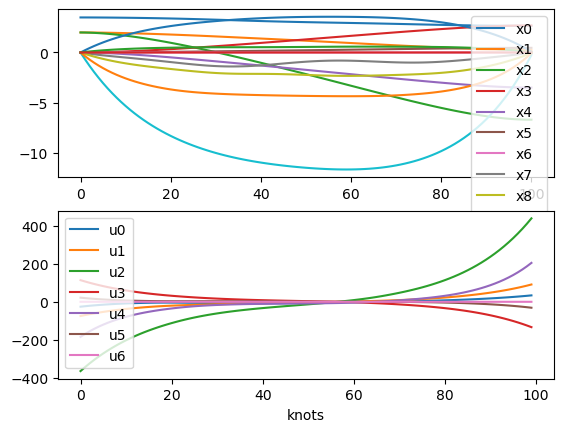

In [18]:
log = ddp.getCallbacks()[0]
crocoddyl.plotOCSolution(log.xs, log.us, figIndex=1)

Some elements describing the solver convergence can also been plotted.

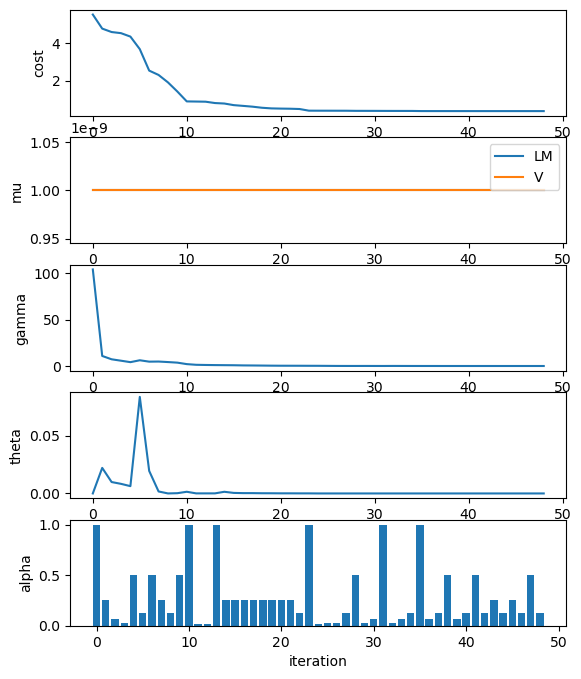

In [19]:
crocoddyl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

## I. DifferentialActionModel for Pinocchio ABA
ABA is a Rigid Body Algorithm optimized to calculate the acceleration in configuration space given the torque.

This scenario uses an action model that computes 2nd order differential dynamics with Pinocchio. Note that it can accept several cost models. This action model is tailored for robot applications, and at the same time, it's modular since:
 - you can modify the robot dynamics by changing Pinocchio model, and
 - you can formulate any cost function by simply adding running and/or terminal costs.

## II. Cost models

A cost model computes a scalar cost value and its gradient and Hessian. All the models implemented are computing a cost residual and are computing the Hessian with the Gauss approximation.

We implemented reusable cost models for controlling 
 - a frame placement (translation or velocity),
 - the center of mass position, and 
 - state  and control spaces.

In the example above, we used the CostModelFrameTranslation which defines a 3d position task, and the state and control regularizers.

All functions are defined by their *model*, which is const, i.e none of its fields is modified by the *calc* and *calcDiff* calls. Temporary buffers are defined in a companion *data*.

In [20]:
dataCollector = crocoddyl.DataCollectorMultibody(robot.data)
trackData = goalTrackingCost.createData(dataCollector)

### II.a Frame position cost

You define a frame ID and the reference position as a 3D array. The cost is the distance between the frame and the target. This cost depends on $\mathbf{x}$ (specifically the configuration $\mathbf{q}$). You can double check the 0s in its gradient.

In [21]:
x = ddp.xs[1].copy()
q = x[:state.nq]
pinocchio.updateFramePlacements(robot.model, robot.data)
pinocchio.computeJointJacobians(robot.model, robot.data, q)
goalTrackingCost.calc(trackData, x)
goalTrackingCost.calcDiff(trackData, x)
print('Lx = ',trackData.Lx) # For gradient
print('Lu = ',trackData.Lu)

Lx =  [ 1.29790498  1.97448753 -0.90634148 -1.6796678  -1.39285419 -0.99949862
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
Lu =  [0. 0. 0. 0. 0. 0. 0.]


### II.b State cost
In this part of the tutorial you must define a State model. It defines 
 - the dimension of the state and its tangent, and
 - the exponential/integrate and difference/log operators.
The operators can described using Pinocchio functions. And the exercite consists on adding them into your State class. Please note crocoddyl has abstract functions for this.

The state cost uses a reference in state space (State.zero() by default). The cost is the distance, computed with state.difference between the current state and the reference. Hence, with this cost, we regularize both position and velocity.

### II.c Control cost

The control cost uses a control reference as in the state cost. The cost is the distance the current control and the reference. Hence the cost regularizes torque commands.

### II.d Add cost models to the differential action model
Each time we want to include a new cost function, we use addCost function inside our DAM. In this function you're also able its weight.

## III. Create the problem with integrated action model
Differential action models describe cost and dynamics in continuous-time, however our optimal control solvers work in discrete-time. We have created the integrated action model in order to deal with this.

In the previous code, we have used an abstract class that uses simpletic Euler rules. In the cartpole exercise you have learnt how to use integrated action models for your problem.

## IV. Callbacks

Callback functions are needed for analysing and debugging the performance of the solver for your specific problem.
For problems defined with Pinocchio, you can display the robot trajectory per each iterate by including CallbackDisplay. With this callback, you can display robot motions with different rates. Additionally, CallbackVerbose prints a message that allows us to understand the behaviour of the solver.

Generally speaking, an user is able to describe any callback function. This function will be run once per iterate and it has access to all data.

## VI. Modifying the example

Start by defining several targets (let's say 4 targets, all at x=0.4, and at y and z being either 0 or 0.4), and display then in the viewer.


In [22]:
viz.delete('world/goal')
goals = np.array([
    [.4, 0., 0.4],
    [.4, 0., 0.],
    [.4, 0.4, 0.4],
    [.4, 0.4, 0.],
])

for i, g in enumerate(goals):
    viz.addBox(f'world/goal{i}',[.1,.1,.1],[0,1,0,1])
    viz.applyConfiguration(f'world/goal{i}',list(g) + [0,0,0,1])

The shooting problem will be composed of 4 sequences of action models. Each sequence consists on T shooting "running" nodes and 1 terminal node. The running nodes mostly have regularization terms, while the terminal nodes have a strong cost toward the respective target.

[ R1,R1,R1 ... R1,T1, R2,R2 .... R2, T2, R3 ... R3, T3, R4 ... R4 ] , T4

First create 4 running models and 4 terminal models cost.

Then you need to add a position cost, and state and control regularization to each running action model. Please  note that for terminal action model is only needed the position cost. Additionally, in the running models, the position cost should be low, and it should be high in the terminal models.
Be carefull ! Intermediate terminal cost should not have $dt=0$

Now create different shooting problem if you need to go through 1, 2, 3 or 4 positions.

Create a DDP solver for this problem and run it.

In [23]:
ddp = crocoddyl.SolverDDP(problem)
ddp.solve()

True

Well, it should not work, at least no on the first shot. The DDP solver is likely not strong enough to accept the random weights that you have selected. 

If it is working nicely from the first shot, display it in the viewer and go take a coffee. But you will likely have to tweak the gains to make it work.

**It is suggested to first optimize only sequence 1. When you are happy with it, add sequence 2 and optimize again, etc.**

OCP allows to reduce the problem to a weight tunning one. However, some research try to automate this weight tunning part.

The solution if you need it:

In [24]:
# %load tp5/generated/general_ddp_4stage
state = crocoddyl.StateMultibody(robot_model)
# The state object containt info about the configspace, the constraint, the velocity, the kinematic values and everything

# State is quite abstract, to have a real solvable OCP we need to define somme cost associated to this model
# We also need to decide the actual dynamic we will follow (called actuation), it means a solver that will be ourf(x,u) AND a way to descretize it

rcms = []
tcms = []

for i in range(4):
    runningCostModel = crocoddyl.CostModelSum(state)  # The state will remain the same during running 
    terminalCostModel = crocoddyl.CostModelSum(state)  # And also for final state

    ### Cost for reaching the target
    pref = crocoddyl.FrameTranslation(FRAME_TIP, goals[i])
    goalTrackingCost = crocoddyl.CostModelFrameTranslation(state, pref)

    ### Cost for regularizing the state about robot_model.x0, running AND terminal
    weights=crocoddyl.ActivationModelWeightedQuad(np.array([1,1,1,1,1,1,1, 1,1,1,1,2,2,2.]))
    xRegCost = crocoddyl.CostModelState(state,weights,robot_model.x0)
    weightsT=crocoddyl.ActivationModelWeightedQuad(np.array([.01,.01,.01,.01,.01,.01,.01, 1,1,1,1,2,2,2.]))
    xRegCostT = crocoddyl.CostModelState(state,weightsT,robot_model.x0)

    ### Cost for keeping the control low: around zeros with uniform weights
    uRegCost = crocoddyl.CostModelControl(state)


    runningCostModel.addCost("gripperPose", goalTrackingCost, .001)  # addCost is a method of CostModelSum that take another CostModel
    runningCostModel.addCost("xReg", xRegCost, 1e-3)  # We also weight the sum of cost
    runningCostModel.addCost("uReg", uRegCost, 1e-6)
    terminalCostModel.addCost("gripperPose", goalTrackingCost, 10)
    terminalCostModel.addCost("xReg", xRegCostT, .01)
    terminalCostModel.addCost("uReg", xRegCostT, 1e-6)

    rcms.append(runningCostModel)
    tcms.append(terminalCostModel)


actuationModel = crocoddyl.ActuationModelFull(state)
dt = 1e-2
# A step in the running step
## We use the freefall forward dynamic as dotx = f(x,u) it could be a contact one (as in prev TP) and so on
### It is the differential model chosen around the state
## We precise the duration of the step dt
## We precise the integration scheme we use 
### It is the integrated model chosen around the differential model
## We precise which cost is used during this step
def make_running_model(rcm):
    runningModel = crocoddyl.IntegratedActionModelEuler(
        crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, rcm), dt)
    runningModel.differential.armature = robot_model.armature
    return runningModel

def make_terminal_model(tcm):
    runningModel = crocoddyl.IntegratedActionModelEuler(
        crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, tcm), 0.)
    runningModel.differential.armature = robot_model.armature
    return runningModel

terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, terminalCostModel), 0.)
terminalModel.differential.armature = robot_model.armature

T = 100
T_inter = 1

def create_problem(n):
    rmseq = []
    for i in range(n - 1):
        rmseq += [make_running_model(rcms[i])] * T
        rmseq += [make_running_model(tcms[i])] * T_inter
    rmseq += [make_running_model(rcms[n-1])] * T
    tm = make_terminal_model(tcms[n-1])
    return crocoddyl.ShootingProblem(robot_model.x0, rmseq, tm)

ddp = crocoddyl.SolverDDP(create_problem(4))
ddp.solve()


Deprecated: Do not use FrameTranslation.

True


Deprecated: Do not use FrameTranslation.
Deprecated: Do not use FrameTranslation.
Deprecated CostModelFrameTranslation: Use ResidualModelFrameTranslation with CostModelResidual
Deprecated CostModelState: Use ResidualModelState with CostModelResidual
Deprecated CostModelState: Use ResidualModelState with CostModelResidual
Deprecated CostModelControl: Use ResidualModelControl with CostModelResidual
Deprecated: Do not use FrameTranslation.
Deprecated: Do not use FrameTranslation.
Deprecated: Do not use FrameTranslation.
Deprecated CostModelFrameTranslation: Use ResidualModelFrameTranslation with CostModelResidual
Deprecated CostModelState: Use ResidualModelState with CostModelResidual
Deprecated CostModelState: Use ResidualModelState with CostModelResidual
Deprecated CostModelControl: Use ResidualModelControl with CostModelResidual
Deprecated: Do not use FrameTranslation.
Deprecated: Do not use FrameTranslation.
Deprecated: Do not use FrameTranslation.
Deprecated CostModelFrameTranslatio

In [28]:
crocutils.displayTrajectory(viz,ddp.xs,ddp.problem.runningModels[0].dt,12)